In [71]:
#pandas and numpy
import pandas as pd
import numpy as np

#Scikit stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import scikitplot as skplt

#for plots
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

#DMBA book utility tools
from dmba import classificationSummary, gainsChart, liftChart

In [72]:
pd.set_option("display.max_columns", None)
wv = pd.read_csv("worldvalues-data.csv", dtype='object', na_values = ['-5', '-4', '-3', '-2', '-1'])
wv.shape

(89565, 440)

In [73]:
wv = wv[["V55", "V58", "V95", "V145", "V229", "V246"]]
wv.describe()

,V55,V58,V95,V145,V229,V246
count,88117,87898,68199,84720,88038,89558
unique,10,9,10,7,8,5
top,8,No children,5,7,Full time,1
freq,16646,26142,19838,20631,28036,79300


In [74]:
wv.replace(['Missing', 'Unknown', 'Not asked', 'Not asked in suvey', 'Not applicable', 'No answer', 'Dont know'], np.nan, inplace=True)
wv.replace(['BH','HT','RU','AR','DE','PS','SE', 'SG', 'TR', 'HT: Dropped out survey; RU: Inappropriate response{Inappropriate}', 'Not asked in survey', 'DE,SE:Inapplicable ; RU:Inappropriate response; HT: Dropped out survey{Inappropriate}'], np.nan, inplace=True)
wv.replace({"V55":{"No choice at all" : 1, "A great deal of choice" : 10}}, inplace=True)
wv.replace({"V58":{"No children" : 0, "1 child" : 1, "2 children" : 2, "3 children" : 3, "4 children" : 4, "5 children" : 5, "6 children" : 6, "7 children" : 7, "8 or more children" : 8}}, inplace=True)
wv.replace({"V95":{"Left" : 1, "Right" : 10}}, inplace=True)
wv.replace({"V145":{"More than once a week" : 1, "Once a week" : 2, "Once a month" : 3, "Only on special holy days" : 4, "Once a year" : 5, "Less often" : 6, "Never, practically never" : 7}}, inplace=True)
wv.replace({"V229":{"Full time" : 1, "Part time" : 2, "Self employed" : 3, "Retired" : 4, "Housewife" : 5, "Students" : 6, "Unemployed" : 7, "Other" : 8}}, inplace=True)
wv[15:25]

,V55,V58,V95,V145,V229,V246
15,7,1,5,2,1,1
16,7,1,5,2,1,1
17,7,2,5,2,5,1
18,7,0,7,2,1,1
19,7,3,6,2,5,1
20,5,0,NaN,7,6,1
21,1,0,NaN,7,7,1
22,5,0,NaN,7,6,1
23,1,0,NaN,7,7,1
24,5,0,NaN,7,1,1


In [75]:
wv = wv.apply(pd.to_numeric)
wv.dropna(inplace=True)
wv.shape

(60981, 6)

In [76]:
wv.isna().sum()

V55     0
V58     0
V95     0
V145    0
V229    0
V246    0
dtype: int64

In [77]:
wv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60981 entries, 0 to 89564
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V55     60981 non-null  float64
 1   V58     60981 non-null  float64
 2   V95     60981 non-null  float64
 3   V145    60981 non-null  float64
 4   V229    60981 non-null  float64
 5   V246    60981 non-null  float64
dtypes: float64(6)
memory usage: 3.3 MB


In [78]:
wv = wv.rename(columns = {"V55" : "Freedom/Control", "V58" : "Number of Children", "V95" : "Political Scale", "V145" : "Religious Attendance", "V229" : "Employment status", "V246" : "Citizenship"})
wv.head()

,Freedom/Control,Number of Children,Political Scale,Religious Attendance,Employment status,Citizenship
0,7.0,0.0,5.0,3.0,6.0,1.0
1,6.0,0.0,5.0,2.0,6.0,1.0
2,6.0,0.0,6.0,2.0,3.0,1.0
3,6.0,0.0,6.0,2.0,1.0,1.0
4,6.0,3.0,5.0,1.0,3.0,1.0


In [79]:
wv['Freedom/Control'] = wv['Freedom/Control'].astype('category')
wv['Number of Children'] = wv['Number of Children'].astype('category')
wv['Political Scale'] = wv['Political Scale'].astype('category')
wv['Religious Attendance'] = wv['Religious Attendance'].astype('category')
wv['Employment status'] = wv['Employment status'].astype('category')
wv['Citizenship'] = wv['Citizenship'].astype('category')

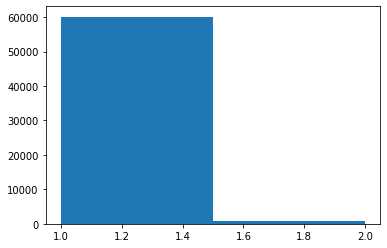

In [100]:
plt.hist(wv['Citizenship'], bins = 2)
plt.show()

In [101]:
wv['Citizenship'].value_counts()

1.0    60123
2.0      858
Name: Citizenship, dtype: int64

In [80]:
# split the original data frame into a train and test using the same random_state
train_df, valid_df = train_test_split(wv, test_size=0.10, random_state=1)

In [81]:
pd.set_option('precision', 3) # to get only 3 digit rounded numbers for probabilities

Lets explore if we can predict citizenship using the responses above

In [82]:
# probability of citizenship
print(train_df['Citizenship'].value_counts() / len(train_df))

1.0    0.986
2.0    0.014
Name: Citizenship, dtype: float64


In [83]:
predictors = ['Employment status', 'Religious Attendance', 'Political Scale', 'Number of Children', 'Freedom/Control']
for predictor in predictors:
    # construct the frequency table
    df = train_df[['Citizenship', predictor]]
    freqTable = df.pivot_table(index='Citizenship', columns=predictor, aggfunc=len)

    # divide each row by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()

Employment status    1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0
Citizenship                                                              
1.0                0.310  0.088  0.143  0.121  0.142  0.075  0.103  0.020
2.0                0.363  0.102  0.108  0.161  0.085  0.057  0.111  0.013

Religious Attendance    1.0    2.0    3.0    4.0    5.0    6.0    7.0
Citizenship                                                          
1.0                   0.153  0.204  0.105  0.165  0.053  0.108  0.212
2.0                   0.102  0.179  0.086  0.166  0.070  0.132  0.265

Political Scale   1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0   \
Citizenship                                                               
1.0              0.071  0.035  0.063  0.072  0.287  0.134  0.102  0.098   
2.0              0.065  0.046  0.070  0.095  0.312  0.163  0.093  0.073   

Political Scale   9.0    10.0  
Citizenship                    
1.0              0.052  0.086  
2.0              0.029  0

Executing Naive Bayes with Scikit-Learn

In [84]:
predictors = ['Employment status', 'Religious Attendance', 'Political Scale', 'Number of Children', 'Freedom/Control']
outcome = 'Citizenship'

X = pd.get_dummies(wv[predictors])
y = (wv[outcome] == 1).astype(int)
classes = [1, 2]

In [85]:
# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=1)

In [86]:
# run naive Bayes
wv_nb = MultinomialNB(alpha=0.01)
wv_nb.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [87]:
#Training performance
y_train_pred = wv_nb.predict(X_train)
classificationSummary(y_train, y_train_pred, class_names=classes)

Confusion Matrix (Accuracy 0.9860)

       Prediction
Actual     1     2
     1     0   766
     2     0 54116


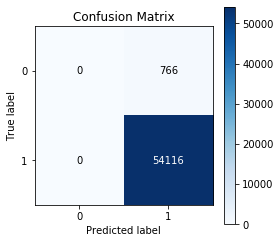

In [88]:
skplt.metrics.plot_confusion_matrix(y_train, y_train_pred, figsize=(4,4), cmap="Blues")

In [89]:
#Testing performance
y_valid_pred = wv_nb.predict(X_valid)
classificationSummary(y_valid, y_valid_pred, class_names=classes)

Confusion Matrix (Accuracy 0.9849)

       Prediction
Actual    1    2
     1    0   92
     2    0 6007


In [90]:
# predicting probabilities
predProb_train = wv_nb.predict_proba(X_train)
predProb_valid = wv_nb.predict_proba(X_valid)

In [91]:
nb_result_tr = pd.DataFrame({'actual': y_train, 
                             'p(0)': [p[0] for p in predProb_train],
                             'p(1)': [p[1] for p in predProb_train],
                             'predicted': y_train_pred})
nb_result_tr.head()

,actual,p(0),p(1),predicted
57595,1,0.020,0.980,1
82678,1,0.008,0.992,1
4869,1,0.022,0.978,1
83292,1,0.004,0.996,1
20793,1,0.016,0.984,1


(array([2.0000e+00, 5.0000e+00, 3.9000e+01, 1.8600e+02, 8.6700e+02,
        3.0970e+03, 7.4370e+03, 1.3146e+04, 1.8996e+04, 1.1107e+04]),
 array([0.93706217, 0.94318927, 0.94931636, 0.95544346, 0.96157056,
        0.96769765, 0.97382475, 0.97995184, 0.98607894, 0.99220604,
        0.99833313]),
 <a list of 10 Patch objects>)

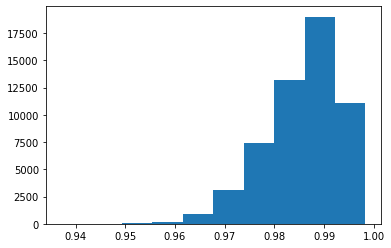

In [92]:
plt.hist(predProb_train[:,1])

In [93]:
# if we cut the probability values at 75%:
ypredclass_tr2 = np.where(predProb_train[:,1] > 0.75, 1, 0)

In [94]:
#Training performance with new cutoff
classificationSummary(y_train, ypredclass_tr2, class_names=classes)

Confusion Matrix (Accuracy 0.9860)

       Prediction
Actual     1     2
     1     0   766
     2     0 54116


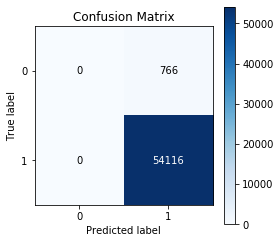

In [95]:
skplt.metrics.plot_confusion_matrix(y_train, ypredclass_tr2, figsize=(4,4), cmap="Blues")

Area under the curve (AUC):
 0.5


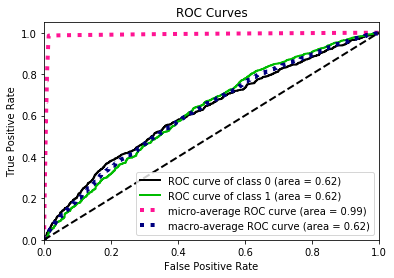

In [96]:
skplt.metrics.plot_roc(y_train, predProb_train)
print("Area under the curve (AUC):\n", roc_auc_score(y_train, y_train_pred))

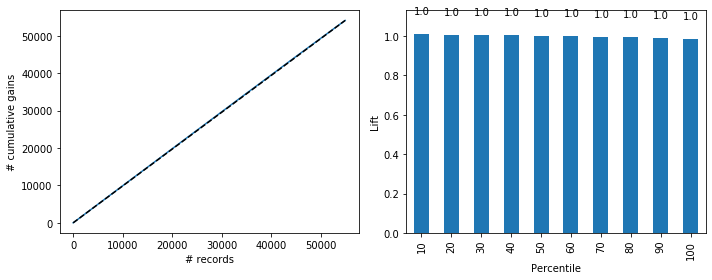

In [97]:
dfgains = nb_result_tr.sort_values(by='p(1)', ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(dfgains.actual, ax=axes[0])
liftChart(dfgains['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()